<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Random Forest

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply random forest classifier for ensamble learning

## Load Dataset

In [2]:
from sklearn.datasets import make_moons

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from IPython.display import Image
import time


In [3]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # default test_size = 0.25

print(f"Train sizes:{ X_train.shape}, {y_train.shape}")
print(f"Test sizes: {X_test.shape}, {y_test.shape}")

Train sizes:(375, 2), (375,)
Test sizes: (125, 2), (125,)


## Random Forest vs. Baggin Classifier
Let's define two models, a Random Forest Clasifier and a Baggin Classifier. Note that to do a fair comparison, I need to set `max_features = 'sqrt'` because `sklearn.ensamble.RandomForestClassifier` samples $\sqrt{n}$ features by default. Additioally, the `RandomForestClassifier` uses `DecisionTreeClassifier` as its base estimator.[[5](#5)][[6](#6)]

In [4]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, oob_score=True, n_jobs=-1, random_state=42)
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16), n_estimators=500, oob_score=True, n_jobs=-1, random_state=42)

In [5]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [6]:
bag_clf.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': 16,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Great! Both models use `gini` to measure splitting quality and `max_samples = 1` for both. Now, let's use the trainig set to fit the models. Furthermore, the two models use sampling with replacement(`bootstrap=True`).

In [7]:
rf_clf.fit(X_train, y_train)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_features='sqrt',
                                                   max_leaf_nodes=16),
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

The following plot shows the decision boundary of each classifier.

In [8]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#F9F7F7', '#3F72AF'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # field
    ax.contour(x1, x2, y_pred, cmap="crest", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels, s=50, alpha=0.5):
    for i in range(len(styles)):
        sns.scatterplot(x=X[:, 0][y == i], y=X[:, 1][y == i], ax=ax, marker=styles[i][0], color=styles[i][1], s=s, edgecolor='k', alpha=alpha)

    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

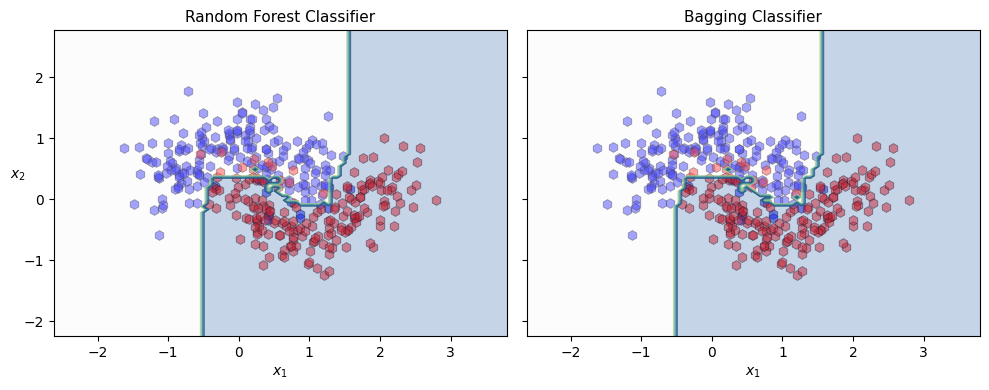

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(rf_clf, X_train, y_train, axes[0])
axes[0].set_title("Random Forest Classifier", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf, X_train, y_train, axes[1])
axes[1].set_title("Bagging Classifier", fontsize=11)

plt.tight_layout()
plt.show()

It is hard to distinguish between the two boundaries. Let's check the scores.

In [10]:
print(f"Random Forest out-of-bag score: {rf_clf.oob_score_:.3f}")
print(f"Bagging Classifier out-of-bag score: {bag_clf.oob_score_:.3f}")

Random Forest out-of-bag score: 0.917
Bagging Classifier out-of-bag score: 0.917


In [11]:
print(f"Random Forest score: {rf_clf.score(X_test, y_test):.3f}")
print(f"Bagging Classifier score: {bag_clf.score(X_test, y_test):.3f}")

Random Forest score: 0.912
Bagging Classifier score: 0.912


Both models achieved the same score on the oob set as well as the test test set.

## Random Forest vs. Extremely Randomize Tree
The __extremely randomize trees__ (aka. __extra-trees__) uses random thresholds for each feature as opposed to searching for the best possible threshold which makes the classifier much fastor to train compare to __random forest classifier__. This randomization is in addition to randomly considering a subset of features for splitting at each node. The side effect of this is that the __extra-trees__ model demonstrates more bias and less variance compared to the __random firest classifier__.[[4](#4)]

In [12]:
xt_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
xt_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
xt_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_leaf_nodes=16, n_estimators=500,
                     n_jobs=-1, oob_score=True, random_state=42)

In [14]:
print(f"Extremely Randomize Tree out-of-bag score: {xt_clf.oob_score_:.3f}")
print(f"Random Forest out-of-bag score: {rf_clf.oob_score_:.3f}")

Extremely Randomize Tree out-of-bag score: 0.899
Random Forest out-of-bag score: 0.917


In [15]:
print(f"Extremely Randomize Tree score: {xt_clf.score(X_test, y_test):.3f}")
print(f"Random Forest score: {rf_clf.score(X_test, y_test):.3f}")

Extremely Randomize Tree score: 0.912
Random Forest score: 0.912


Although, the oob score of the extra-trees model is lower than the random forest, their scores on the test set are the same. This is attributed to the fact that threshold randomization in extra-trees model makes it more regularized, but it also helps the model to generalize better.

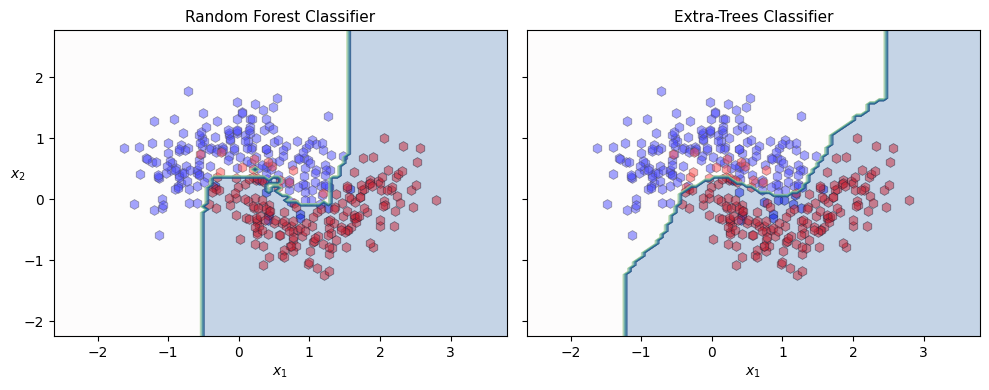

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(rf_clf, X_train, y_train, axes[0])
axes[0].set_title("Random Forest Classifier", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(xt_clf, X_train, y_train, axes[1])
axes[1].set_title("Extra-Trees Classifier", fontsize=11)

plt.tight_layout()
plt.show()

### Bias and Variance

The total error computed as

$$Error(X) = Bias^2 + Variance + Irreducable \  Error$$

where
$$Bias^2 = \frac{1}{n}\sum_{i=1}^{n}\left(y_i - E(\hat{f}(x_i))\right)^2,$$
<br>
$$Variance = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{m}\sum_{j=1}^{m}\left(\hat{f}_j(x_i)-\hat{f}(x_i)\right)^2,$$

and Irreducable Error, $\sigma_e^2$, which can not be reduced by creating good models. Irreducable Error is a measure of the amount of noise in the data.<br>
Here are the list of the notations that I used  in the above formulas:

* $y_i$ is the target value (ground truth)
* $\hat{f}(x_i)$ is the prediction for instance $i$
* $E(\hat{f}(x_i))$ is the expected (average) prediction for instance $i$
* $\hat{f}_j(x_i)$ is the prediction from model $j$ for instace $i$.


### cross-val-score

In order to compute the bias and variance, I need to compute the accuracy scores over multiple folds of the training or test set first. I will use the `cross_val_score` for this purpose. The accuracy score computes the accuracy, either the fraction (default) or the count (normalize=Flase) of correct predictions[[3](#3)]. As a reminder

* __<u>Accuracy</u>__ measures how close a given set of observations are to their true value. It is a description of _<u>systematic errors</u>_ and a measure of _<u>bias</u>_
* __<u>Precision</u>__ measures how close the observations are to each other. It is a description of _<u>random errors</u>_ and a measure of _<u>variability</u>_.

<div style='background-color: white'>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Accuracy_and_precision.svg/1920px-Accuracy_and_precision.svg.png' width='300'></center>
</div>

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0. It is defined as

$$accuracy(y,\hat{y}) = \frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}1(\hat{y_i}=y_i)$$

where $\hat{y_i}$ is the predicted value of the $i$-th sample, $y_i$ is the corresponding true value, and $1(x)$ is the indicator function.<a id=#1>[[1](#1)]


In [17]:
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
xt_scores = cross_val_score(xt_clf, X_train, y_train, cv=5, scoring='accuracy')

This will provides us with 5 scores (because `cv=5`), and each score indicates what fraction of the valiation set in that fold is predicted accurately using the fitting model in that fold. Here are the socres for the random forest classifier for instance.

In [18]:
rf_scores

array([0.90666667, 0.94666667, 0.88      , 0.96      , 0.89333333])

The accuracy varies between $88\%$ and $96\%$. The scores' average indicates the overall accuracy of the model on the training set and one minus the scores' average is a measure of bias.

In [19]:
f"{1-rf_scores.mean():.3f}"

'0.083'

The variance of this score is also a determination of the model variance which indicates the variability of the accuracies.

In [20]:
f"{rf_scores.var():.5f}"

'0.00095'

Let's summarize by taking a look at the bias and variance of the model over the training set.

In [21]:
print(f"Random forest: (bias) {1-np.mean(rf_scores):.3f}, (var) {np.var(rf_scores):.5f}")
print(f"Extra-trees: (bias) {1-np.mean(xt_scores):.3f}, (var) {np.var(xt_scores):.5f}")

Random forest: (bias) 0.083, (var) 0.00095
Extra-trees: (bias) 0.104, (var) 0.00074


### cross-val-predict

Another method to compute the bias is to get the predictions and compute the error manually. In order to do so I need to use `cross_val_predict`. According to the documentation, [[2](#2)],  it generate cross-validated estimates for each input data point. The data is split according to the cv parameter. Each sample belongs to exactly one test set, and its prediction is computed with an estimator fitted on the corresponding training set.

In [22]:
y_pred_rf = cross_val_predict(rf_clf, X_train, y_train, cv=5) # shape = (375,)
y_pred_xt = cross_val_predict(xt_clf, X_train, y_train, cv=5)

To compute the average accuracy, I need to compute what fraction of the predictions is equal to their true value, i.e.,

$$ y_i=\hat{y_i} \quad \text{or} \quad y_i-\hat{y_i}=0 $$

Let's do this for the random forest model.



In [23]:
f"{((y_train - y_pred_rf)==0).sum()/y_pred_rf.shape[0]:.3f}"

'0.917'

This should match the scores' average for the random forest model.

In [24]:
f"{rf_scores.mean():.3f}"

'0.917'

So the bias is the fraction that is predicted incorrectly. However, to cancel the effect of the negative values and emphasize the influence of the outliers generally root mean square error (RMSE) is computed. For classification tasks I can also use mean absolute error (MAE) since the result of $y_i - \hat{y_i}$ is either zero or $-1$. But it is common to use RMSE in regression tasks.

In [25]:
print(f"RMSE: {np.sqrt(np.mean((y_train - y_pred_rf)**2)):.3f}")
print(f"MAE: {np.mean(np.abs(y_train - y_pred_rf)):.3f}")

RMSE: 0.288
MAE: 0.083


The value of MAE matches the one I computed directly from the cross validation socres. since RMSE is more common, I will use it to compare the models' performance.<br>
The variance is still obtained by computing the variance of the scores. Let's simmarize the bias and variance of the two models below. The results should match those we got earlier using only `cross-val-scores`.

In [26]:
print(f"Random Forest: (bias) {np.sqrt(np.mean((y_train - y_pred_rf)**2)):.3f}, (var) {np.var(rf_scores):.5f}")
print(f"Extra-trees: (bias) {np.sqrt(np.mean((y_train - y_pred_xt)**2)):.3f}, (var) {np.var(xt_scores):.5f}")

Random Forest: (bias) 0.288, (var) 0.00095
Extra-trees: (bias) 0.322, (var) 0.00074


### Compare Renadom Forest and Extra-Trees

Here is a summary of the bia and variance results that I computeed:<br>

|Model|Bias<br>(MAE)|bias<br>(RMSE)|Variance|
|:----|:----:|:----:|:----:|
|Random Forest|0.083|0.288|0.00095|
|Extra-Trees|0.104|0.322|0.00074|

Comparing to the random forest model, the bias of the extre-trees model increased and while its variance decreased. as mentioned earlier, this arributed to the randomize selection of the threshold value for splitting.<br>

I can use _MAE_ or _RMSE_ scoring methods directly to minimize the post-processing as follows.


In [38]:
scorings = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']

for scoring in scorings:
    rf_scores_ = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring=scoring)
    xt_scores_ = cross_val_score(xt_clf, X_train, y_train, cv=5, scoring=scoring)

    print(f"Random forest ({scoring}): (bias) {-np.mean(rf_scores_):.3f}, (var) {np.var(rf_scores_):.5f}")
    print(f"Extra-trees ({scoring}): (bias) {-np.mean(xt_scores_):.3f}, (var) {np.var(xt_scores_):.5f}\n")


Random forest (neg_mean_absolute_error): (bias) 0.083, (var) 0.00095
Extra-trees (neg_mean_absolute_error): (bias) 0.104, (var) 0.00074

Random forest (neg_root_mean_squared_error): (bias) 0.282, (var) 0.00320
Extra-trees (neg_root_mean_squared_error): (bias) 0.319, (var) 0.00215



The bias and variance of the MAE methos is identical to computed earlier. The bias values are slightly off for the RMSE method, and the variance is diffeent as expected, becasue it is now the variation the root mean squared of the errors. Regardless the same trend is observed when I compare these values between the two models (higher bias and lower variance for exrta-trees).

Finally, I compute the scores one more time, but on the whole dataset instead of just the training set in order to compare the bias and variance of the two classifiers.

In [39]:
rf_scores_all = cross_val_score(rf_clf, X, y, cv=5, scoring='neg_mean_absolute_error')
xt_scores_all = cross_val_score(xt_clf, X, y, cv=5, scoring='neg_mean_absolute_error')

In [40]:
print(f"Random forest: (bias) {-np.mean(rf_scores_all):.3f}, (var) {np.var(rf_scores_all):.5f}")
print(f"Extra-trees: (bias) {-np.mean(xt_scores_all):.3f}, (var) {np.var(xt_scores_all):.5f}\n")

Random forest: (bias) 0.088, (var) 0.00018
Extra-trees: (bias) 0.096, (var) 0.00010



Similar trends as expected!

## References:

1. <a id='1' href='https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score'>Scikit-Learn: Matrics and Scoring</a>

2. <a id='2' href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#cross-val-predict'> Scikit-Learn: cross-val-predict</a>

3. <a id='3' href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score'>Scikit-Learn: cross-val-score</a>

4. <a id='4' href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier'>Scikit-Learn: ExtraTreesClassifier</a>

5. <a id='5' href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'>Scikit-Learn:RandomForestClassifier</a>

6. <a id='6' href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html'>Scikit-Learn:BaggingClassifier</a>

7. <a id='7' href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Scikit-Learn: DecisionTreeClassifier</a>